In [1]:
import hyperspy.api as hs
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import binary_blobs, brick

### Create dataset

We create a synthetic EDS dataset from two EDS spectra.

In [2]:
fe = hs.load('Fe.hspy')
pt = hs.load('Pt.hspy')

/home/eric/Dev/hyperspy/hyperspy/io_plugins/hspy.py:143: UserWarning: This file was written using a newer version of the HyperSpy hdf5 file format. I will attempt to load it, but, if I fail, it is likely that I will be more successful at this and other tasks if you upgrade me.
  warnings.warn(


<AxesSubplot:xlabel='Energy (keV)', ylabel='Intensity'>

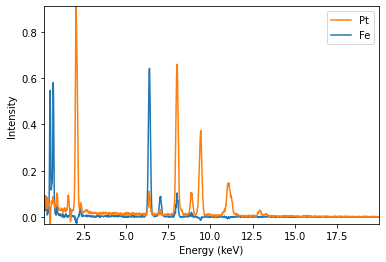

In [3]:
hs.plot.plot_spectra([fe, pt], legend=['Fe', 'Pt'])

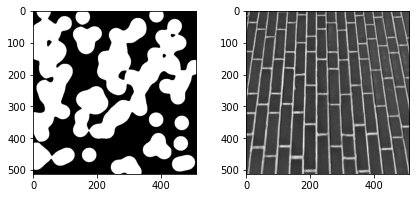

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].imshow(binary_blobs(), cmap='gray')
axs[1].imshow(brick(), cmap='gray')

In [36]:
def create_dask_array(signal_chunk=1):
    nav0 = 150 * binary_blobs().flatten() * da.random.random((512 * 512), chunks=(1024*8*signal_chunk,))
    sig0 = da.from_array(fe.data, fe.data.shape[0] / signal_chunk)
    data0 = da.outer(nav0, sig0).reshape((512, 512, fe.data.shape[0]))

    nav1 = brick().flatten() * da.random.random((512 * 512), chunks=(1024*8*signal_chunk,))
    sig1 = da.from_array(pt.data, pt.data.shape[0] / signal_chunk)
    data1 = da.outer(nav1, sig1).reshape((512, 512, pt.data.shape[0]))

    return data0 + data1

In [37]:
data = create_dask_array(4)

In [38]:
data

dask.array<add, shape=(512, 512, 992), dtype=float64, chunksize=(64, 512, 248), chunktype=numpy.ndarray>

In [39]:
s = hs.signals.EDSTEMSpectrum(data).as_lazy()
axis = s.axes_manager[-1]
axis_ref = fe.axes_manager[-1]
for attr in ('scale', 'units', 'offset'):
    setattr(axis, attr, getattr(axis_ref, attr))
s.add_elements(('Fe', 'Pt'))

In [40]:
s.axes_manager

<Axes manager, axes: (512, 512|992)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     <undefined> |    512 |      0 |       0 |       1 | <undefined> 
     <undefined> |    512 |      0 |       0 |       1 | <undefined> 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |    992 |        |    0.16 |    0.02 |    keV

### Save dataset

In [41]:
s.save('synthetic_dataset.hspy')

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 21.9 µs


Overwrite '/home/eric/Dev/hyperspy_tutorial/07 Big data/synthetic_dataset.hspy' (y/n)?
 y


Save a dataset with a single chunk in the signal dimension

In [45]:
s.data = create_dask_array(1)

In [46]:
s.data

dask.array<add, shape=(512, 512, 992), dtype=float64, chunksize=(16, 512, 992), chunktype=numpy.ndarray>

In [47]:
s.save('synthetic_dataset_chunking.hspy')

Overwrite '/home/eric/Dev/hyperspy_tutorial/07 Big data/synthetic_dataset_chunking.hspy' (y/n)?
 y
